In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import statistics

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from livelossplot import PlotLossesKeras

# free data capture limits for some sources
# Get stock data from tiingo
# Ge treaury data from Quandl
import requests

#You need this for prediction date extraction
import time
from datetime import datetime, date, time, timedelta

nan=np.nan

In [2]:
DBGmode = 0
WritetoFile = 1

pd.set_option('display.max_rows', 30)
ticker = 'PYPL'
st_date = '2020-1-1'
en_date = '2020-9-21'

timestep = 3
TrainPCT = 0.85

ADDUS10Y = 1

ADDXMA = 0
xmasmall = 7
xmalong = 21

ADDRSI = 0
RSIwindow = 14

ADDSTOCHRSI = 1
SRSIw = 14
SRSIk = 3
SRSId = 3

epochval = 10 #iter when entire dataset is passed fwd/back thru NN
batchval = 1  #training examples in a singler batch

In [3]:
us10y_data = quandl.get("FRED/DGS10", start_date=st_date, end_date=en_date, api_key = 'tNjFxT5wYAG7nbemafxi')
us10y_data=us10y_data.reset_index()
us10y_data.rename(columns = {'Value':'US10Y'}, inplace = True) 

if DBGmode==1:
    us10y_data

In [4]:
for row in range(0,len(us10y_data)):
    us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
us10y_data=us10y_data.set_index('Date')

if DBGmode==1:
    us10y_data

<ipython-input-4-83275a74f87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = f'https://api.tiingo.com/tiingo/daily/{stock_symbol}/prices?'
    token = '59e2dfca5859e44a55ef766a8f81aab1ab8a80e8'
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'token': token
    }
    response = requests.get(base_url, params=payload)
    return response

In [6]:
response = get_stock_data(ticker, st_date, en_date)

if DBGmode == 1:
    print(response.url)
    print(response.json())

In [7]:
def parse_data(data_response):
    json_data = data_response.json()
    dates = []
    closes =[]
    opens = []
    highs = []
    lows = []
    vols = []
    for json_object in json_data:
        dates.append(json_object['date'])
        closes.append(json_object['close'])
        opens.append(json_object['open'])
        highs.append(json_object['high'])
        lows.append(json_object['low'])
        vols.append(json_object['volume'])
    return dates, closes, opens, highs, lows, vols

In [8]:
dates, closes, opens, highs, lows, vols = parse_data(response)

if DBGmode == 1:
    print(dates, closes)

In [9]:
#**** Define New Column Label here
datastock = pd.DataFrame(columns = ['Close'], index = dates)
dfindex = datastock.index
dfindex.name = 'Date'

In [10]:
#**** ADD New Column Data here
datastock['Close']=closes
#datastock['Volume']=vols

if DBGmode == 1:
    datastock

In [11]:
if DBGmode == 1:
    plt.plot(datastock['Close'], label=ticker+' Closes')
    plt.legend()
    plt.show()

In [12]:
print('Total Stock Rows = ', len(datastock))
print('Total US10Y Rows = ', len(us10y_data))

if ADDUS10Y==1:
    #****APPEND US10Y data here to a separate column in a new dataframe
    data=pd.concat([datastock, us10y_data], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data['US10Y'].fillna(method='ffill', inplace=True)

else:
    data=datastock
    
data

Total Stock Rows =  182
Total US10Y Rows =  181


,Close,US10Y
2020-01-02T00:00:00.000Z,110.75,1.88
2020-01-03T00:00:00.000Z,108.76,1.80
2020-01-06T00:00:00.000Z,110.17,1.81
2020-01-07T00:00:00.000Z,109.67,1.83
2020-01-08T00:00:00.000Z,111.82,1.87
...,...,...
2020-09-15T00:00:00.000Z,186.02,0.68
2020-09-16T00:00:00.000Z,180.91,0.69
2020-09-17T00:00:00.000Z,175.79,0.69
2020-09-18T00:00:00.000Z,176.07,0.70


In [13]:
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=xmasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=xmalong).mean()

    #Enter EMA Data - defined at the top
    data['Close-XMA'+str(xmasmall)] = data.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data['Close-XMA'+str(xmalong)] = data.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow=xmalong
    data.drop(data.index[0:droprow], inplace = True)

In [14]:
def computeRSI(series, period=14):
    # calculating RSI (gives the same values as TradingView)
    # https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    return 100 - 100 / (1 + rs)

In [15]:
def StochRSI_EMA(series, period=14, smoothK=3, smoothD=3):
    #link from https://gist.github.com/ultragtx/6831eb04dfe9e6ff50d0f334bdcb847d
    # calculating Stoch RSI (gives the same values as TradingView)
    # https://www.tradingview.com/wiki/Stochastic_RSI_(STOCH_RSI) 
    # uses EMA, not SMA
    
    # Calculate RSI
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.ewm(span=smoothK).mean()
    stochrsi_D = stochrsi_K.ewm(span=smoothD).mean()

    return stochrsi, stochrsi_K, stochrsi_D

In [16]:
#Add RSI here
if ADDRSI == 1:
    data['Close-RSI'+str(RSIwindow)] = computeRSI(data['Close'], RSIwindow)
    #data.drop(data.index[0:RSIwindow], inplace = True)

In [17]:
#Add STOCHRSI here
if ADDSTOCHRSI == 1:
    data['Close-SRSI'+str(SRSIw)], data['Close-SRSIk'+str(SRSIk)], data['Close-SRSId'+str(SRSId)] = StochRSI_EMA(data['Close'], SRSIw, SRSIk, SRSId)
    #data.drop(data.index[0:SRSIw*2], inplace = True)

In [18]:
#Drop rows on which RSI or SRSI are first computed
if ADDRSI == 1 and ADDSTOCHRSI == 1:
    data.drop(data.index[0:max(RSIwindow,SRSIw*2)], inplace = True)
if ADDRSI == 0 and ADDSTOCHRSI == 1:
    data.drop(data.index[0:SRSIw*2], inplace = True)
if ADDRSI == 1 and ADDSTOCHRSI == 0:
    data.drop(data.index[0:RSIwindow], inplace = True)

In [19]:
data_noofcols = len(data.columns)
print('Number of data columns = ', data_noofcols)

Number of data columns =  5


In [20]:
print(data[:timestep])

                           Close  US10Y  Close-SRSI14  Close-SRSIk3  \
2020-02-12T00:00:00.000Z  118.56   1.62      0.379847      0.368344   
2020-02-13T00:00:00.000Z  120.51   1.61      0.771443      0.598687   
2020-02-14T00:00:00.000Z  122.99   1.59      1.000000      0.812720   

                          Close-SRSId3  
2020-02-12T00:00:00.000Z      0.360676  
2020-02-13T00:00:00.000Z      0.496682  
2020-02-14T00:00:00.000Z      0.665236  


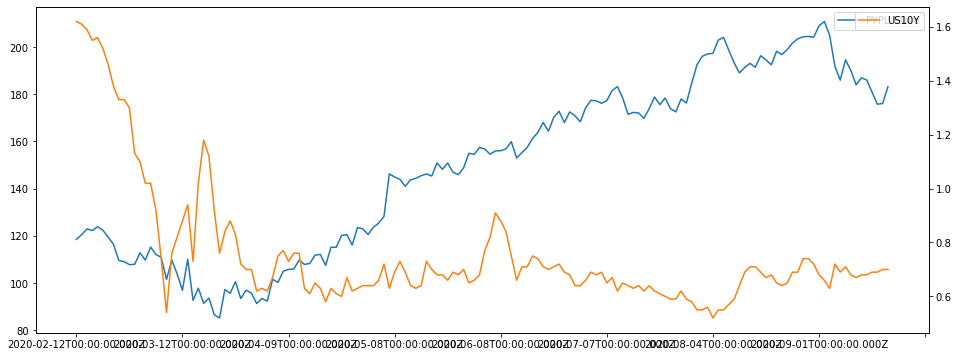

In [21]:
plt.figure()
data['Close'].plot(figsize=(16,6), label=ticker+'-Close')
if ADDXMA==1:
    data['Close-XMA'+str(xmasmall)].plot(label=ticker+'-EMA'+str(xmasmall))
    data['Close-XMA'+str(xmalong)].plot(label=ticker+'-EMA'+str(xmalong))
plt.legend()
if ADDUS10Y==1:
    data['US10Y'].plot(secondary_y=True, label='US10Y')
plt.legend()
plt.show()

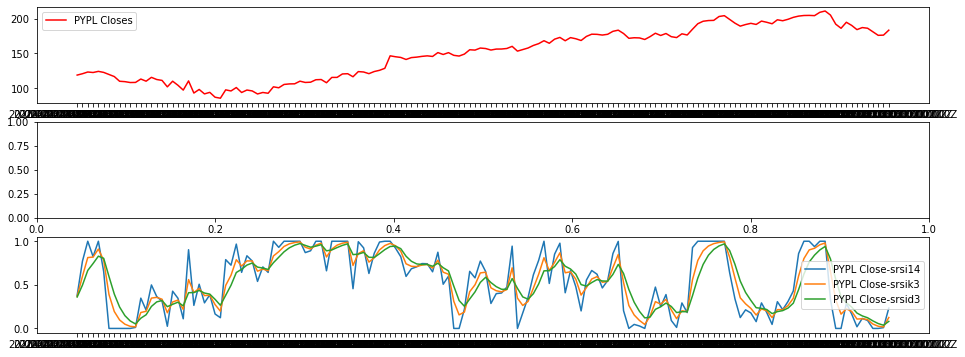

In [22]:
fig, axs = plt.subplots(3,1,figsize=(16,6))
axs[0].plot(data['Close'], color='r', label=ticker+' Closes')
if ADDXMA==1:
    axs[0].plot(data['Close-XMA'+str(xmasmall)], label=ticker+' Close-ema'+str(xmasmall))
    axs[0].plot(data['Close-XMA'+str(xmalong)], label=ticker+' Close-ema'+str(xmalong))
axs[0].legend()
if ADDRSI==1:
    axs[1].plot(data['Close-RSI'+str(RSIwindow)], label=ticker+' Close-rsi'+str(RSIwindow))
    axs[1].legend()
if ADDSTOCHRSI==1:
    axs[2].plot(data['Close-SRSI'+str(SRSIw)], label=ticker+' Close-srsi'+str(SRSIw))
    axs[2].plot(data['Close-SRSIk'+str(SRSIk)], label=ticker+' Close-srsik'+str(SRSIk))
    axs[2].plot(data['Close-SRSId'+str(SRSId)], label=ticker+' Close-srsid'+str(SRSId))
    axs[2].legend()
plt.show()

In [23]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print('Length of scaled_data = ', len(scaled_data))
print(scaled_data)

Length of scaled_data =  154
[[2.65211851e-01 1.00000000e+00 3.79846651e-01 3.59714533e-01
  3.45826064e-01]
 [2.80742275e-01 9.90909091e-01 7.71443432e-01 5.95773439e-01
  4.90979172e-01]
 [3.00493788e-01 9.72727273e-01 1.00000000e+00 8.15118968e-01
  6.70868895e-01]
 [2.94759478e-01 9.36363636e-01 8.23449839e-01 8.20794172e-01
  7.55159845e-01]
 [3.07820962e-01 9.45454545e-01 1.00000000e+00 9.15398431e-01
  8.45341172e-01]
 [2.96033769e-01 9.09090909e-01 6.52632789e-01 7.82187724e-01
  8.19457122e-01]
 [2.72618668e-01 8.54545455e-01 0.00000000e+00 3.80639899e-01
  5.96759653e-01]
 [2.48327493e-01 7.81818182e-01 0.00000000e+00 1.81044698e-01
  3.81931128e-01]
 [1.94329404e-01 7.36363636e-01 0.00000000e+00 8.15397595e-02
  2.22968549e-01]
 [1.89949028e-01 7.36363636e-01 0.00000000e+00 3.18602053e-02
  1.17722740e-01]
 [1.79834342e-01 7.09090909e-01 0.00000000e+00 7.03862589e-03
  5.22105230e-02]
 [1.81028990e-01 5.54545455e-01 1.18371252e-02 6.98566567e-04
  1.61647115e-02]
 [2.1981522

In [24]:
train_length = int(len(scaled_data) * TrainPCT)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

if DBGmode == 1:
    print('scaled_data length =', len(scaled_data))
    print('train_length = ', train_length)
    print('test_length = ', test_length)
    print(train_data)
    print(test_data)

In [25]:
def create_dataset(dataset, noofcols, timestep=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep):
        data_x.append(dataset[i:(i+timestep),0:noofcols])
        data_y.append(dataset[i+timestep,0])
    #It has been shown that Numpy arrays need 4 times less memory compared to Python lists
    return np.array(data_x), np.array(data_y)

In [26]:
train_x, train_y = create_dataset(train_data, data_noofcols, timestep)
test_x, test_y = create_dataset(test_data, data_noofcols, timestep)

if DBGmode == 1:
    print(train_x)

In [27]:
if DBGmode == 1:
    print(train_y)

In [28]:
print('#Samples, #Timesteps, #Features - for input to LSTM')
print('train_x shape = ', train_x.shape)
print('test_x shape = ', test_x.shape)
print('train_y shape = ', train_y.shape)
print('test_y shape = ', test_y.shape)

#Samples, #Timesteps, #Features - for input to LSTM
train_x shape =  (127, 3, 5)
test_x shape =  (21, 3, 5)
train_y shape =  (127,)
test_y shape =  (21,)


In [29]:
##Samples, #Timesteps, #Features - for input to LSTM'
#train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], data_noofcols))
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], data_noofcols))

if DBGmode == 1:
    print(train_x)

In [30]:
#optimizer = 'adam' 'SGD' 'RMSprop' 'adadelta' 'adagrad' 'adamax' 'nadam' 'ftrl'
#activation = 'sigmoid' 'linear' relu' 'softmax' 'softplus' 'softsign' 'tanh' selu' 'elu' 'exponential' 
#loss = 'binary_crossentropy' 'mean_squared_error'

#LSTM input_shape = #timestep, #features
model = Sequential()
#model.add(LSTM(256, input_shape=(1,data_noofcols)))
model.add(LSTM(50, return_sequences=True, input_shape=(timestep,data_noofcols)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(25))
model.add(Dense(1))
#model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 50)             11200     
_________________________________________________________________
dropout (Dropout)            (None, 3, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 32,701
Trainable params: 32,701
Non-trainable params: 0
____________________________________________________

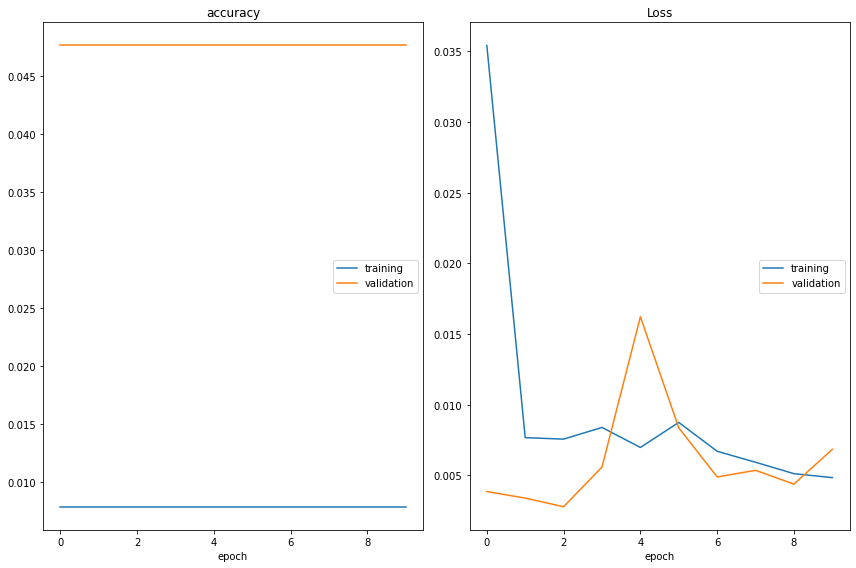

accuracy
	training         	 (min:    0.008, max:    0.008, cur:    0.008)
	validation       	 (min:    0.048, max:    0.048, cur:    0.048)
Loss
	training         	 (min:    0.005, max:    0.035, cur:    0.005)
	validation       	 (min:    0.003, max:    0.016, cur:    0.007)
127/127 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 0.0079 - val_loss: 0.0068 - val_accuracy: 0.0476
Keras model loss =  0.005759014282375574
Keras model accuracy =  0.007874015718698502


In [31]:
#model.fit(train_x, train_y, epochs=epochval, batch_size=batchval, verbose=1, validation_data=(test_x, test_y))

#Use plotting
model.fit(train_x, train_y, epochs=epochval, batch_size=batchval, verbose=1, validation_data=(test_x, test_y), callbacks=[PlotLossesKeras()])

score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

In [32]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

if DBGmode == 1:
    print(train_predictions)

In [33]:
#Perform inverse Scaler transform

# create empty table with data_noofcols fields
train_predictions_like = np.zeros(shape=(len(train_predictions), data_noofcols))
# put the predicted values in the right field
train_predictions_like[:,0] = train_predictions[:,0]
# inverse transform and then select the right field
train_predictions = scaler.inverse_transform(train_predictions_like)[:,0]

# create empty table with 2 fields
test_predictions_like = np.zeros(shape=(len(test_predictions), data_noofcols))
# put the predicted values in the right field
test_predictions_like[:,0] = test_predictions[:,0]
# inverse transform and then select the right field
test_predictions = scaler.inverse_transform(test_predictions_like)[:,0]

In [34]:
if DBGmode == 1:
    print(train_predictions)
    print(test_predictions)

In [35]:
#train_predict_plot = np.empty_like(scaled_data[:,0])
train_predict_plot = scaled_data[:,0]
train_predict_plot[:] = np.nan
train_predict_plot[timestep:len(train_predictions)+timestep] = train_predictions

In [36]:
if DBGmode==1:
    print(test_predictions)

In [37]:
test_predict_plot = np.empty_like(scaled_data[:,0])
test_predict_plot[:] = np.nan
test_predict_plot[
    len(train_predictions)+timestep+timestep:len(scaled_data)] = test_predictions

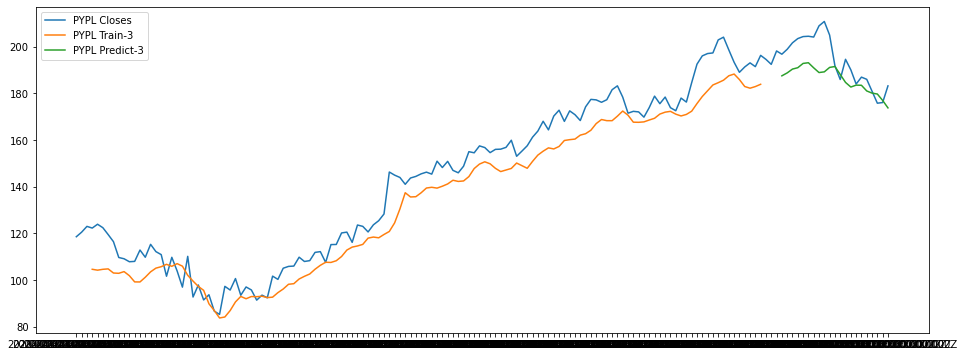

In [38]:
plt.figure(figsize=(16,6))
plt.plot(data.Close, label = ticker+' Closes')
plt.plot(train_predict_plot, label = ticker+' Train-'+str(timestep))
plt.plot(test_predict_plot, label = ticker+' Predict-'+str(timestep))
plt.legend()
plt.show()

In [39]:
print('Number of data[Close] rows = ', len(data['Close']))
print('Length of Train data = ', len(train_predictions))
print('Length of test data = ', len(test_predictions))

Number of data[Close] rows =  154
Length of Train data =  127
Length of test data =  21


In [40]:
data['AITrain'] = train_predict_plot
data['AITest'] = test_predict_plot
data

,Close,US10Y,Close-SRSI14,Close-SRSIk3,Close-SRSId3,AITrain,AITest
2020-02-12T00:00:00.000Z,118.56,1.62,0.379847,0.368344,0.360676,NaN,NaN
2020-02-13T00:00:00.000Z,120.51,1.61,0.771443,0.598687,0.496682,NaN,NaN
2020-02-14T00:00:00.000Z,122.99,1.59,1.000000,0.812720,0.665236,NaN,NaN
2020-02-18T00:00:00.000Z,122.27,1.55,0.823450,0.818258,0.744215,104.605995,NaN
2020-02-19T00:00:00.000Z,123.91,1.56,1.000000,0.910571,0.828714,104.224482,NaN
...,...,...,...,...,...,...,...
2020-09-15T00:00:00.000Z,186.02,0.68,0.091307,0.101261,0.122514,NaN,181.038819
2020-09-16T00:00:00.000Z,180.91,0.69,0.000000,0.050631,0.086572,NaN,180.109416
2020-09-17T00:00:00.000Z,175.79,0.69,0.000000,0.025315,0.055944,NaN,179.724920
2020-09-18T00:00:00.000Z,176.07,0.70,0.009366,0.017340,0.036642,NaN,176.973413


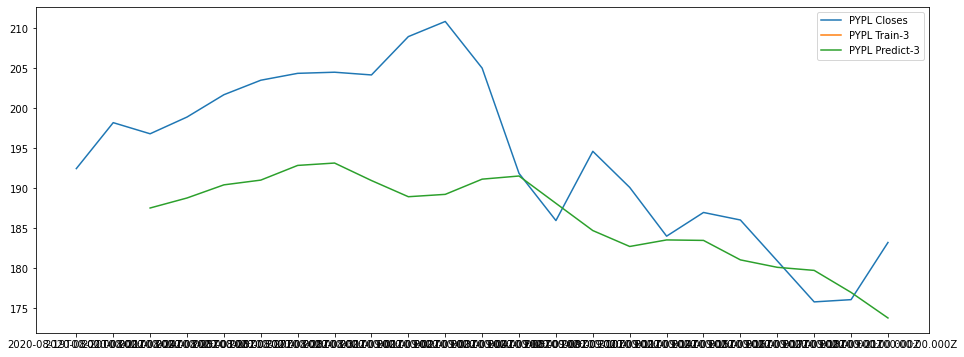

In [41]:
plt.figure(figsize=(16,6))
plt.plot(data.Close[-timestep-20:], label = ticker+' Closes')
plt.plot(train_predict_plot[-timestep-20:], label = ticker+' Train-'+str(timestep))
plt.plot(test_predict_plot[-timestep-20:], label = ticker+' Predict-'+str(timestep))
plt.legend()
plt.show()

In [42]:
data['Abs%Err']=nan
data['DirErr']=nan

In [43]:
#-----STOCK PRICE PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep,len(scaled_data)):
    data['Abs%Err'][i]=100*(data['AITest'][i]-data['Close'][i])/data['Close'][i]

#-----DIRECTION PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep+1,len(scaled_data)):
    parity=0
    if ((data['Close'][i] - data['Close'][i-1])*(data['AITest'][i] - data['AITest'][i-1])) > 0:
        data['DirErr'][i]=0
        parity=1
    if parity==0:
        data['DirErr'][i]=1

if DBGmode==1:
    print('Train length = ', len(train_predictions)+timestep)
    print('Total length = ', len(scaled_data))
    ch=len(train_predictions)+timestep+timestep+1
    print('data[Close][i]   = ', data['Close'][ch])
    print('data[Close][i-1] = ', data['Close'][ch-1])
    print('data[AITest][i]= ', data['AITest'][ch])
    print('data[AITest][i-1]= ', data['AITest'][ch-1])
    print('data[DirErr][i]  = ', data['DirErr'][ch])

In [44]:
if DBGmode==1:
    print(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
    print(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)])

In [45]:
Tot_test_error = sum(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
Tot_test_len = sum(data['DirErr'].notnull())
Test_DirAcc = 100*(Tot_test_len - Tot_test_error) / Tot_test_len
print('timestep=', timestep)
print('')
print('----DIRECTION----- \n')
print('Total Test Errors = ', Tot_test_error)
print('Total Test Elements = ', Tot_test_len)
print('Test Direction Predict Accuracy = ', Test_DirAcc)
print('')
print('----STOCK PRICE PREDICTION----- \n')
len(train_predictions)+timestep,len(scaled_data)-timestep
print('Max % Price Error = ', max(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Min % Price Error = ', min(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Average % Price Error = ', statistics.mean(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))

timestep= 3

----DIRECTION----- 

Total Test Errors =  8.0
Total Test Elements =  20
Test Direction Predict Accuracy =  60.0

----STOCK PRICE PREDICTION----- 

Max % Price Error =  2.2384210592841054
Min % Price Error =  -10.244713718711779
Average % Price Error =  -3.8738401952907666


In [46]:
if WritetoFile == 1:
    data.to_csv(ticker+'_predict.csv')
    print('Wrote to file')

Wrote to file


In [47]:
if DBGmode == 0:
    pd.set_option('display.max_rows', data.shape[0]+1)
    data

print('timestep=', timestep)
data.tail(timestep+10)

timestep= 3


,Close,US10Y,Close-SRSI14,Close-SRSIk3,Close-SRSId3,AITrain,AITest,Abs%Err,DirErr
2020-09-02T00:00:00.000Z,210.82,0.66,1.000000,0.979818,0.939984,NaN,189.222095,-10.244714,0.0
2020-09-03T00:00:00.000Z,204.99,0.63,0.331437,0.655627,0.797806,NaN,191.122040,-6.765189,1.0
2020-09-04T00:00:00.000Z,191.84,0.72,0.000000,0.327814,0.562810,NaN,191.515359,-0.169225,1.0
2020-09-08T00:00:00.000Z,185.95,0.69,0.000000,0.163907,0.363358,NaN,188.101858,1.157224,0.0
2020-09-09T00:00:00.000Z,194.60,0.71,0.287435,0.225671,0.294515,NaN,184.699905,-5.087408,1.0
2020-09-10T00:00:00.000Z,190.09,0.68,0.165797,0.195734,0.245124,NaN,182.712914,-3.880839,0.0
2020-09-11T00:00:00.000Z,184.00,0.67,0.019291,0.107513,0.176319,NaN,183.530424,-0.255204,1.0
2020-09-14T00:00:00.000Z,186.96,0.68,0.114918,0.111216,0.143767,NaN,183.470784,-1.866290,1.0
2020-09-15T00:00:00.000Z,186.02,0.68,0.091307,0.101261,0.122514,NaN,181.038819,-2.677766,0.0
2020-09-16T00:00:00.000Z,180.91,0.69,0.000000,0.050631,0.086572,NaN,180.109416,-0.442531,0.0


In [48]:
#*******************************************************************
#*****************Predict for next day from here********************
#*******************************************************************
#Remember to use _ob nomenclature for clean separation

st_date_ob = '2018-1-1' #doesnt really matter, we will take on -timestep elements
en_date_ob = datetime.date(datetime.now())
#yday = today - timedelta(days=1)
response_ob = get_stock_data(ticker, st_date_ob, en_date_ob)
dates_ob, closes_ob, opens_ob, highs_ob, lows_ob, vols_ob = parse_data(response_ob)

#**** Define New Column Label here
datastock_ob = pd.DataFrame(columns = ['Close'], index = dates_ob)
dfindex_ob = datastock_ob.index
dfindex_ob.name = 'Date'

#**** ADD New Column Data here
datastock_ob['Close']=closes_ob

if ADDUS10Y==1:
    us10y_data_ob = quandl.get("FRED/DGS10", start_date=st_date_ob, end_date=en_date_ob, api_key = 'tNjFxT5wYAG7nbemafxi')
    us10y_data_ob=us10y_data_ob.reset_index()
    us10y_data_ob.rename(columns = {'Value':'US10Y'}, inplace = True) 
    
    for row in range(0,len(us10y_data_ob)):
        us10y_data_ob['Date'][row]=str(us10y_data_ob['Date'][row])[:10]+'T00:00:00.000Z'
    us10y_data_ob=us10y_data_ob.set_index('Date')
    
    #****APPEND US10Y data here to a separate column in a new dataframe
    data_ob=pd.concat([datastock_ob, us10y_data_ob], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data_ob['US10Y'].fillna(method='ffill', inplace=True)
else:
    data_ob=datastock_ob
    
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #xmasmall=5
    #xmalong=9
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=smasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=smalong).mean()

    #Enter EMA Data - defined at the top
    #xmasmall=7
    #xmalong=14
    data_ob['Close-XMA'+str(xmasmall)] = data_ob.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data_ob['Close-XMA'+str(xmalong)] = data_ob.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow_ob=xmalong
    data_ob.drop(data_ob.index[0:droprow_ob], inplace = True)

#Add RSI here
if ADDRSI == 1:
    data_ob['Close-RSI'+str(RSIwindow)] = computeRSI(data_ob['Close'], RSIwindow)
    #data.drop(data.index[0:RSIwindow], inplace = True)
    
#Add STOCHRSI here
if ADDSTOCHRSI == 1:
    data_ob['Close-SRSI'+str(SRSIw)], data_ob['Close-SRSIk'+str(SRSIk)], data_ob['Close-SRSId'+str(SRSId)] = StochRSI_EMA(data_ob['Close'], SRSIw, SRSIk, SRSId)
    #data.drop(data.index[0:SRSIw*2], inplace = True)

#Drop rows on which RSI or SRSI are first computed
if ADDRSI == 1 and ADDSTOCHRSI == 1:
    data_ob.drop(data_ob.index[0:max(RSIwindow,SRSIw*2)], inplace = True)
if ADDRSI == 0 and ADDSTOCHRSI == 1:
    data_ob.drop(data_ob.index[0:SRSIw*2], inplace = True)
if ADDRSI == 1 and ADDSTOCHRSI == 0:
    data_ob.drop(data_ob.index[0:RSIwindow], inplace = True)
    
data_noofcols_ob = len(data_ob.columns)

datafilt_ob = data_ob[-timestep:]
print('datafilt_ob')
print(datafilt_ob)

scaled_datafilt_ob = scaler.transform(datafilt_ob)
print('\n scaled_datafilt_ob')
print(scaled_datafilt_ob)

data_x_ob = []
data_x_ob.append(scaled_datafilt_ob)
data_x_ob = np.array(data_x_ob)
print('\n data_x_ob shape = ', data_x_ob.shape)
print('\n data_x_ob')
print(data_x_ob)
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[2], 1))

train_predictions_ob = model.predict(data_x_ob)
print('\n train_predictions_ob')
print(train_predictions_ob)

# create empty table with data_noofcols fields
train_predictions_like_ob = np.zeros(shape=(len(train_predictions_ob), data_noofcols_ob))
# put the predicted values in the right field
train_predictions_like_ob[:,0] = train_predictions_ob[:,0]
# inverse transform and then select the right field
train_predictions_ob = scaler.inverse_transform(train_predictions_like_ob)[:,0]

print('\n inverse scaled train_predictions_ob')
print(train_predictions_ob)

datafilt_ob
                           Close  US10Y  Close-SRSI14  Close-SRSIk3  \
2020-09-18T00:00:00.000Z  176.07    0.7      0.009366      0.017341   
2020-09-21T00:00:00.000Z  183.21    0.7      0.233176      0.125258   
2020-09-22T00:00:00.000Z  187.78    0.7      0.357401      0.241330   

                          Close-SRSId3  
2020-09-18T00:00:00.000Z      0.036642  
2020-09-21T00:00:00.000Z      0.080950  
2020-09-22T00:00:00.000Z      0.161140  

 scaled_datafilt_ob
[[7.23239885e-01 1.63636364e-01 9.36566734e-03 8.95289242e-09
  2.12484224e-08]
 [7.80105129e-01 1.63636364e-01 2.33176175e-01 1.10596058e-01
  4.72879767e-02]
 [8.16502071e-01 1.63636364e-01 3.57401085e-01 2.29547991e-01
  1.32870759e-01]]

 data_x_ob shape =  (1, 3, 5)

 data_x_ob
[[[7.23239885e-01 1.63636364e-01 9.36566734e-03 8.95289242e-09
   2.12484224e-08]
  [7.80105129e-01 1.63636364e-01 2.33176175e-01 1.10596058e-01
   4.72879767e-02]
  [8.16502071e-01 1.63636364e-01 3.57401085e-01 2.29547991e-01
   1.32

<ipython-input-48-b946d6d4981c>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data_ob['Date'][row]=str(us10y_data_ob['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [49]:
print(ticker, ' predict = ', float(train_predictions_ob), ' on ', en_date_ob)

PYPL  predict =  176.62531893491746  on  2020-09-22
